In [55]:
# import packages
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
from scipy import stats
import statistics
import plotly.graph_objects as go
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Data importation and preprocessing

In [56]:
df = pd.read_excel("/files/exercises/Project/Final project - Financial econometrics.xlsx") # import the data
df = df.drop(columns=["Repeated fund", 'Unique funds']) # drop useless columns
df = df.iloc[:, [6, 7, 8, 4, 5, 10, 3, 2, 9, 1]] # Rearrange the column in a convenient way (see the regressions in the loop later)
df = df.fillna(df.mean()) # remplace missing values by the mean of the column
df['Rate'] = df['Rate'].round(0).values # The missing values were remplaced by their mean. We want only integer so we round it

## Data visualisation

In [57]:
# It will allow us to build the two barplots below

bars = ['EUR', 'GBP', 'USD', 'CHF', 'SEK', 'SGD', 'JPY']
y_pos = np.arange(len(bars))
height = df['Currency'].value_counts().values

bars2 = ['LUX', 'IRL', 'FR', 'RU', 'SP', 'NOR']
y_pos2 = np.arange(len(bars2))
height2 = df['Country'].value_counts().values

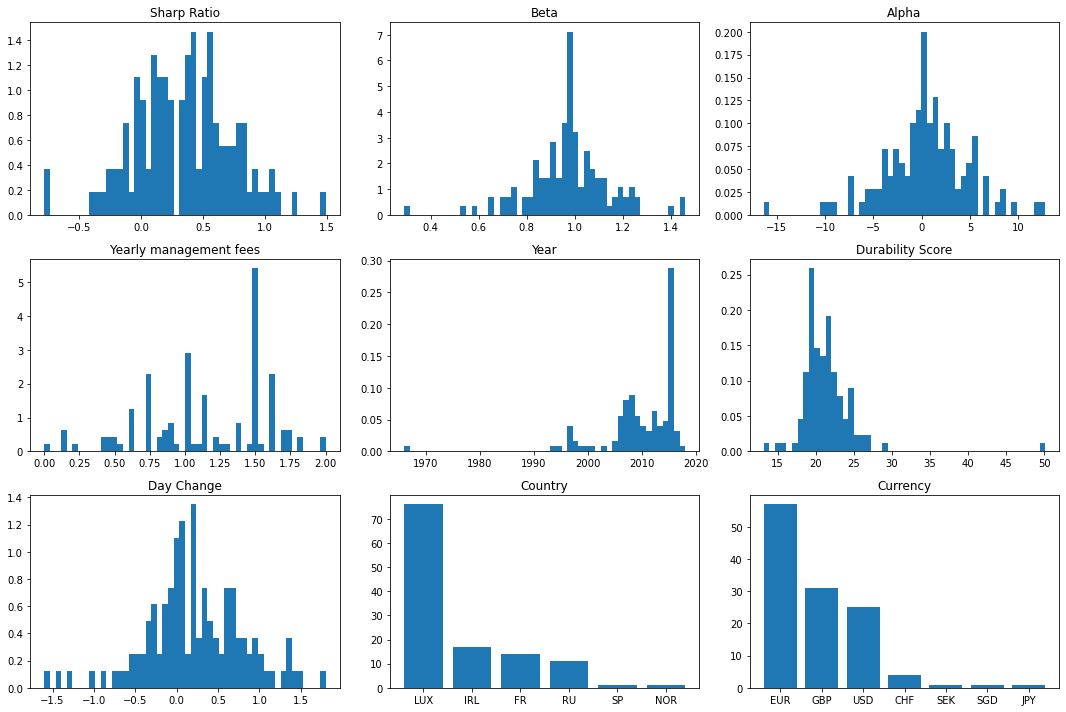

In [58]:
# Plot histograms for numerous variables and barplots for categorical variables

n_bins = 50

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()

ax0.hist(df['Sharp Ratio'], n_bins, density=True, histtype='bar')
ax0.set_title('Sharp Ratio')

ax1.hist(df['Beta'], n_bins, density=True, histtype='bar')
ax1.set_title('Beta')

ax2.hist(df['Alpha'], n_bins, density=True, histtype='bar')
ax2.set_title('Alpha')

ax3.hist(df['Yearly management fees'], n_bins, density=True, histtype='bar')
ax3.set_title('Yearly management fees')

ax4.hist(df['Year'], n_bins, density=True, histtype='bar')
ax4.set_title('Year')

ax5.hist(df['Durability Score'], n_bins, density=True, histtype='bar')
ax5.set_title('Durability Score')

ax6.hist(df['Day Change'], n_bins, density=True, histtype='bar')
ax6.set_title('Day Change')

ax7.bar(y_pos2, height2)
ax7.set_xticks(y_pos2)
ax7.set_xticklabels(bars2)
ax7.set_title('Country')

ax8.bar(y_pos, height)
ax8.set_xticks(y_pos)
ax8.set_xticklabels(bars)
ax8.set_title('Currency')


fig.tight_layout()
plt.show()

In [59]:
df['Rate'] = df['Rate'].astype('category') # compute the dependent variable as type 'category'

In [60]:
# It will allow us to build the barplot below

bars3 = ['0', '1', '2', '3', '4', '5']
y_pos3 = np.arange(len(bars3))
height3 = df['Rate'].value_counts().values[[4, 5, 3, 0, 2, 1]]

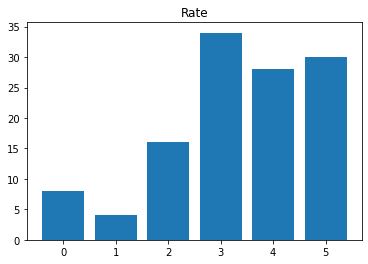

In [61]:
# Plot barplots for the dependent variable

plt.bar(y_pos3, height3)
plt.title('Rate')

plt.show()

In [62]:
# Create dummies for categorical variables. It will help for the regressions

df = pd.get_dummies(df, columns=['Currency', 'Country'], drop_first = True)

## Inference using logistic and linear regression and prediction on TRAIN dataset

In [63]:
# Compute logistic and linear regression in the TRAIN dataset

accuracy_train = np.ones([2,3]) # Create a vector where we are going to save the accuracy of our predictions
Error_train = np.ones([2,3]) # Create a vector where we are going to save the average error of our predictions

X = df[df.drop('Rate', axis=1).columns[:18]] # Save the independent variables in X

# Scaled the variables (substract the mean and divide by the standard deviation) it seems that logistic function does not converge when X is not scaled
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

y = df['Rate'] # Save the dependent variable on y
    
# Split the original data in a train (70%) and test dataset (30%)
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y, test_size=3/10, random_state=122)

# Split the variables according to their model
X_train_good = train_X[:,:5]
X_train_bad = train_X[:,5:18]
X_train_all = train_X[:,:18]
    
X_test_good = test_X[:,:5]
X_test_bad = test_X[:,5:18]
X_test_all = test_X[:,:18]

# Run the logistic regression
model_LOG = LogisticRegression(solver = 'lbfgs')
mod_good_LOG = model_LOG.fit(X_train_good, train_y)
model_LOG = LogisticRegression(solver = 'lbfgs')
mod_bad_LOG = model_LOG.fit(X_train_bad, train_y)
model_LOG = LogisticRegression(solver = 'lbfgs')
mod_all_LOG = model_LOG.fit(X_train_all, train_y)
    
# Run the linear regression
model_good_OLS = sm.OLS(endog = train_y, exog = X_train_good, missing='drop')
mod_good_OLS = model_good_OLS.fit()
model_bad_OLS = sm.OLS(endog = train_y, exog = X_train_bad, missing='drop')
mod_bad_OLS = model_bad_OLS.fit()
model_all_OLS = sm.OLS(endog = train_y, exog = X_train_all, missing='drop')
mod_all_OLS = model_all_OLS.fit()
    
# Predict on the TRAIN dataset
y_pred_good_LOG = mod_good_LOG.predict(X_train_good)
y_pred_bad_LOG = mod_bad_LOG.predict(X_train_bad)
y_pred_all_LOG = mod_all_LOG.predict(X_train_all)
    
y_pred_good_OLS = mod_good_OLS.predict(X_train_good)
y_pred_good_OLS = y_pred_good_OLS.round()
y_pred_good_OLS = np.where(y_pred_good_OLS > 5, 5, y_pred_good_OLS)
y_pred_good_OLS = np.where(y_pred_good_OLS < 0, 0, y_pred_good_OLS)

y_pred_bad_OLS = mod_bad_OLS.predict(X_train_bad)
y_pred_bad_OLS = y_pred_bad_OLS.round()
y_pred_bad_OLS = np.where(y_pred_bad_OLS > 5, 5, y_pred_bad_OLS)
y_pred_bad_OLS = np.where(y_pred_bad_OLS < 0, 0, y_pred_bad_OLS)
    
y_pred_all_OLS = mod_all_OLS.predict(X_train_all)
y_pred_all_OLS = y_pred_all_OLS.round()
y_pred_all_OLS = np.where(y_pred_all_OLS > 5, 5, y_pred_all_OLS)
y_pred_all_OLS = np.where(y_pred_all_OLS < 0, 0, y_pred_all_OLS)

# Compute the average error and accuracy
Error_train[0,0] = math.sqrt(sum((train_y.astype('float') - y_pred_good_LOG)**2)/len(train_y))
Error_train[0,1] = math.sqrt(sum((train_y.astype('float') - y_pred_bad_LOG)**2)/len(train_y))
Error_train[0,2] = math.sqrt(sum((train_y.astype('float') - y_pred_all_LOG)**2)/len(train_y))
Error_train[1,0] = math.sqrt(sum((train_y.astype('float') - y_pred_good_OLS)**2)/len(train_y))
Error_train[1,1] = math.sqrt(sum((train_y.astype('float') - y_pred_bad_OLS)**2)/len(train_y))
Error_train[1,2] = math.sqrt(sum((train_y.astype('float') - y_pred_all_OLS)**2)/len(train_y))
    
accuracy_train[0,0] = metrics.accuracy_score(train_y, y_pred_good_LOG)
accuracy_train[0,1] = metrics.accuracy_score(train_y, y_pred_bad_LOG)
accuracy_train[0,2] = metrics.accuracy_score(train_y, y_pred_all_LOG)
accuracy_train[1,0] = metrics.accuracy_score(train_y, y_pred_good_OLS)
accuracy_train[1,1] = metrics.accuracy_score(train_y, y_pred_bad_OLS)
accuracy_train[1,2] = metrics.accuracy_score(train_y, y_pred_all_OLS)
    
first_cm_LOG_train = metrics.confusion_matrix(train_y, y_pred_good_LOG)
first_cm_OLS_train = metrics.confusion_matrix(train_y, y_pred_good_OLS)
        
second_cm_LOG_train = metrics.confusion_matrix(train_y, y_pred_bad_LOG)
second_cm_OLS_train = metrics.confusion_matrix(train_y, y_pred_bad_OLS)
        
third_cm_LOG_train = metrics.confusion_matrix(train_y, y_pred_all_LOG)
third_cm_OLS_train = metrics.confusion_matrix(train_y, y_pred_all_OLS)

## Inference using logistic and linear regression and prediction on TEST dataset

In [64]:
# Compute logistic and OLS regression in the TEST dataset

accuracy_test = np.ones([2,3]) # Create a vector where we are going to save the accuracy of our predictions
Error_test = np.ones([2,3]) # Create a vector where we are going to save the average error of our predictions
    
X = df[df.drop('Rate', axis=1).columns[:18]] # Save the independent variables in X

# Scaled the variables (substract the mean and divide by the standard deviation) it seems that logistic function does not converge when X is not scaled
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

y = df['Rate'] # Save the dependent variable on y
    
# Split the original data in a train (70%) and test dataset (30%)
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y, test_size=3/10, random_state=122)
    
# Split the variables according to their model
X_train_good = train_X[:,:5]
X_train_bad = train_X[:,5:18]
X_train_all = train_X[:,:18]
    
X_test_good = test_X[:,:5] 
X_test_bad = test_X[:,5:18]
X_test_all = test_X[:,:18]

# Run the logistic regression
model_LOG = LogisticRegression(solver = 'lbfgs')
mod_good_LOG = model_LOG.fit(X_train_good, train_y)
model_LOG = LogisticRegression(solver = 'lbfgs')
mod_bad_LOG = model_LOG.fit(X_train_bad, train_y)
model_LOG = LogisticRegression(solver = 'lbfgs')
mod_all_LOG = model_LOG.fit(X_train_all, train_y)
    
# Run the linear regression
model_good_OLS = sm.OLS(endog = train_y, exog = X_train_good, missing='drop')
mod_good_OLS = model_good_OLS.fit()
model_bad_OLS = sm.OLS(endog = train_y, exog = X_train_bad, missing='drop')
mod_bad_OLS = model_bad_OLS.fit()
model_all_OLS = sm.OLS(endog = train_y, exog = X_train_all, missing='drop')
mod_all_OLS = model_all_OLS.fit()
    
# Predict on the TEST dataset
y_pred_good_LOG = mod_good_LOG.predict(X_test_good)
y_pred_bad_LOG = mod_bad_LOG.predict(X_test_bad)
y_pred_all_LOG = mod_all_LOG.predict(X_test_all)
    
y_pred_good_OLS = mod_good_OLS.predict(X_test_good)
y_pred_good_OLS = y_pred_good_OLS.round()
y_pred_good_OLS = np.where(y_pred_good_OLS > 5, 5, y_pred_good_OLS)
y_pred_good_OLS = np.where(y_pred_good_OLS < 0, 0, y_pred_good_OLS)

y_pred_bad_OLS = mod_bad_OLS.predict(X_test_bad)
y_pred_bad_OLS = y_pred_bad_OLS.round()
y_pred_bad_OLS = np.where(y_pred_bad_OLS > 5, 5, y_pred_bad_OLS)
y_pred_bad_OLS = np.where(y_pred_bad_OLS < 0, 0, y_pred_bad_OLS)
    
y_pred_all_OLS = mod_all_OLS.predict(X_test_all)
y_pred_all_OLS = y_pred_all_OLS.round()
y_pred_all_OLS = np.where(y_pred_all_OLS > 5, 5, y_pred_all_OLS)
y_pred_all_OLS = np.where(y_pred_all_OLS < 0, 0, y_pred_all_OLS)

# Compute the average error and accuracy
Error_test[0,0] = math.sqrt(sum((test_y.astype('float') - y_pred_good_LOG)**2)/len(test_y))
Error_test[0,1] = math.sqrt(sum((test_y.astype('float') - y_pred_bad_LOG)**2)/len(test_y))
Error_test[0,2] = math.sqrt(sum((test_y.astype('float') - y_pred_all_LOG)**2)/len(test_y))
Error_test[1,0] = math.sqrt(sum((test_y.astype('float') - y_pred_good_OLS)**2)/len(test_y))
Error_test[1,1] = math.sqrt(sum((test_y.astype('float') - y_pred_bad_OLS)**2)/len(test_y))
Error_test[1,2] = math.sqrt(sum((test_y.astype('float') - y_pred_all_OLS)**2)/len(test_y))
    
accuracy_test[0,0] = metrics.accuracy_score(test_y, y_pred_good_LOG)
accuracy_test[0,1] = metrics.accuracy_score(test_y, y_pred_bad_LOG)
accuracy_test[0,2] = metrics.accuracy_score(test_y, y_pred_all_LOG)
accuracy_test[1,0] = metrics.accuracy_score(test_y, y_pred_good_OLS)
accuracy_test[1,1] = metrics.accuracy_score(test_y, y_pred_bad_OLS)
accuracy_test[1,2] = metrics.accuracy_score(test_y, y_pred_all_OLS)
    
first_cm_LOG_test = metrics.confusion_matrix(test_y, y_pred_good_LOG)
first_cm_OLS_test = metrics.confusion_matrix(test_y, y_pred_good_OLS)
        
second_cm_LOG_test = metrics.confusion_matrix(test_y, y_pred_bad_LOG)
second_cm_OLS_test = metrics.confusion_matrix(test_y, y_pred_bad_OLS)
        
third_cm_LOG_test = metrics.confusion_matrix(test_y, y_pred_all_LOG)
third_cm_OLS_test = metrics.confusion_matrix(test_y, y_pred_all_OLS)

## Confusion matrix (TRAIN prediction)

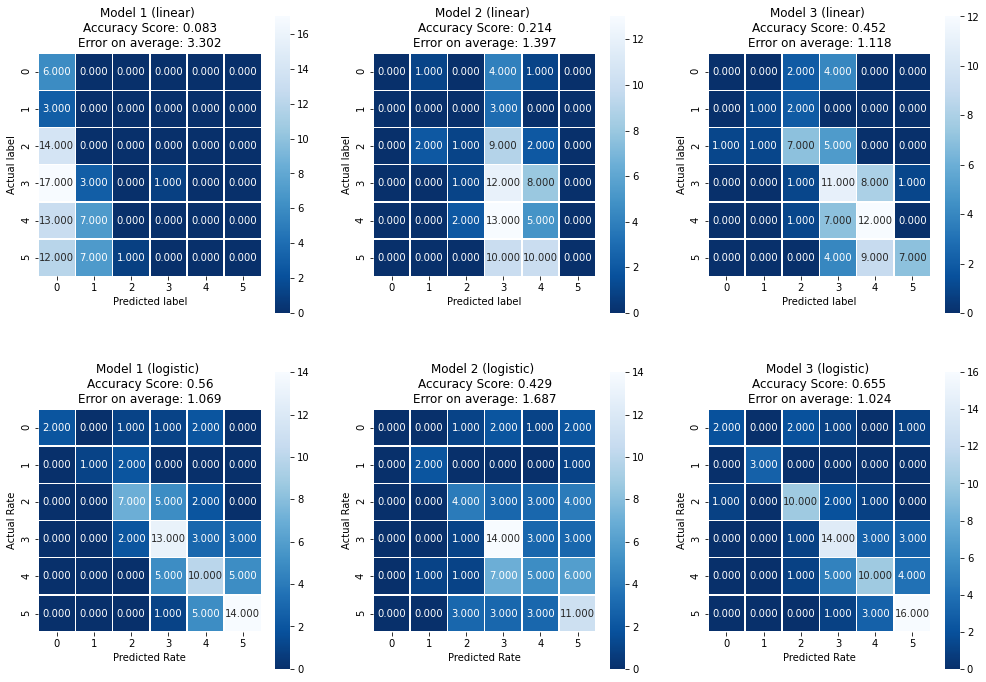

In [65]:
# Plot the 3 confusion matrix 
# Those in the first line have been build using the predictions (on TRAIN dataset) with the linear model 

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17,12))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

sns.heatmap(first_cm_OLS_train, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax0);
ax0.set_title('Model 1 (linear) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_train[1,0].round(3),  Error_train[1,0].round(3)))
ax0.set(xlabel='Predicted label', ylabel='Actual label')
sns.heatmap(second_cm_OLS_train, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax1);
ax1.set_title('Model 2 (linear) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_train[1,1].round(3),  Error_train[1,1].round(3)))
ax1.set(xlabel='Predicted label', ylabel='Actual label')
sns.heatmap(third_cm_OLS_train, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax2);
ax2.set_title('Model 3 (linear) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_train[1,2].round(3),  Error_train[1,2].round(3)))
ax2.set(xlabel='Predicted label', ylabel='Actual label')

# The second line correspond to those using the logistic model predictions (on TRAIN dataset).

sns.heatmap(first_cm_LOG_train, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax3);
ax3.set_title('Model 1 (logistic) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_train[0,0].round(3),  Error_train[0,0].round(3)))
ax3.set(xlabel='Predicted Rate', ylabel='Actual Rate')
sns.heatmap(second_cm_LOG_train, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax4);
ax4.set_title('Model 2 (logistic) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_train[0,1].round(3),  Error_train[0,1].round(3)))
ax4.set(xlabel='Predicted Rate', ylabel='Actual Rate')
sns.heatmap(third_cm_LOG_train, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax5);
ax5.set_title('Model 3 (logistic) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_train[0,2].round(3),  Error_train[0,2].round(3)))
ax5.set(xlabel='Predicted Rate', ylabel='Actual Rate')

plt.show()

## Confusion matrix (TEST prediction)

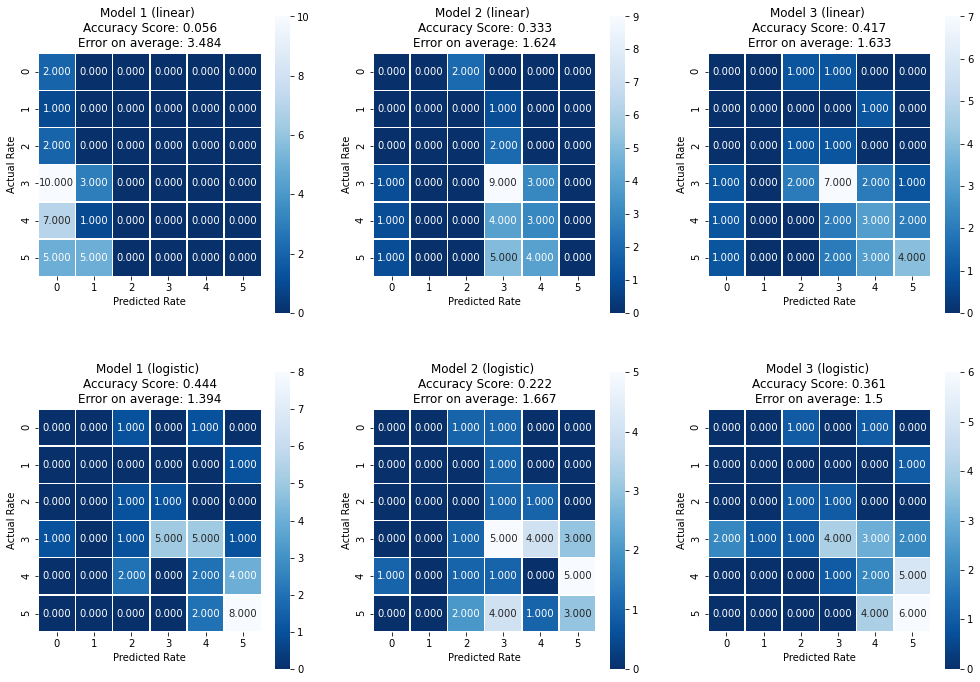

In [66]:
# Plot the 3 confusion matrix 
# Those in the first line have been build using the predictions (on TEST dataset) with the linear model 

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17,12))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

sns.heatmap(first_cm_OLS_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax0);
ax0.set_title('Model 1 (linear) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_test[1,0].round(3),  Error_test[1,0].round(3)))
ax0.set(xlabel='Predicted Rate', ylabel='Actual Rate')
sns.heatmap(second_cm_OLS_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax1);
ax1.set_title('Model 2 (linear) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_test[1,1].round(3),  Error_test[1,1].round(3)))
ax1.set(xlabel='Predicted Rate', ylabel='Actual Rate')
sns.heatmap(third_cm_OLS_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax2);
ax2.set_title('Model 3 (linear) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_test[1,2].round(3),  Error_test[1,2].round(3)))
ax2.set(xlabel='Predicted Rate', ylabel='Actual Rate')

# The second line correspond to those using the logistic model predictions (on TEST dataset).

sns.heatmap(first_cm_LOG_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax3);
ax3.set_title('Model 1 (logistic) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_test[0,0].round(3),  Error_test[0,0].round(3)))
ax3.set(xlabel='Predicted Rate', ylabel='Actual Rate')
sns.heatmap(second_cm_LOG_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax4);
ax4.set_title('Model 2 (logistic) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_test[0,1].round(3),  Error_test[0,1].round(3)))
ax4.set(xlabel='Predicted Rate', ylabel='Actual Rate')
sns.heatmap(third_cm_LOG_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax5);
ax5.set_title('Model 3 (logistic) \nAccuracy Score: {0}\nError on average: {1}'.format(accuracy_test[0,2].round(3),  Error_test[0,2].round(3)))
ax5.set(xlabel='Predicted Rate', ylabel='Actual Rate')

plt.show()

## Accuracy (TRAIN prediction)

In [67]:
# Compute the accuracy using the predictions (on TRAIN dataset) with logit model.

pd.DataFrame(accuracy_train, index = ['Logistic accuracy', 'Linear accuracy'], columns = ['Model 1', 'Model 2', 'Model 3'])

,Model 1,Model 2,Model 3
Logistic accuracy,0.559524,0.428571,0.654762
Linear accuracy,0.083333,0.214286,0.452381


## Average error (TRAIN prediction)

In [68]:
# Compute the average error using the predictions (on TRAIN dataset) with logit model.

pd.DataFrame(Error_train, index = ['Logistic accuracy', 'Linear accuracy'], columns = ['Model 1', 'Model 2', 'Model 3'])

,Model 1,Model 2,Model 3
Logistic accuracy,1.069045,1.686783,1.023533
Linear accuracy,3.302236,1.397276,1.118034


## Accuracy matrix (TEST prediction)

In [69]:
# Compute the accuracy using the predictions (on TEST dataset) with logit model.

pd.DataFrame(accuracy_test, index = ['Logistic accuracy', 'Linear accuracy'], columns = ['Model 1', 'Model 2', 'Model 3'])

,Model 1,Model 2,Model 3
Logistic accuracy,0.444444,0.222222,0.361111
Linear accuracy,0.055556,0.333333,0.416667


## Average error (TEST prediction)

In [70]:
# Compute the average error using the predictions (on TEST dataset) with logit model.

pd.DataFrame(Error_test, index = ['Logistic accuracy', 'Linear accuracy'], columns = ['Model 1', 'Model 2', 'Model 3'])

,Model 1,Model 2,Model 3
Logistic accuracy,1.394433,1.666667,1.500000
Linear accuracy,3.484091,1.624466,1.632993
